Running a simulation with SHyFT
=========

### This notebook is guiding through the simulation process of a catchment. The following steps are described:
1. **Loading required python modules and setting path to SHyFT installation**
2. **Configuration of a SHyFT simulation**
3. **Running a SHyFT simulation**
4. **Post-processing:** Fetching simulation results from the simulator-object.

<i>© Felix Matt, University of Oslo</i>

### 1. Loading required python modules and setting path to SHyFT installation

In [2]:
# python modules
%pylab inline
import os
from os import path
import sys
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
# set the path for your shyft build
# this should point to the directory that is created
# when you clone shyft, assuming you have built shyft
# there and not installed it to your system python
shyft_path = os.path.abspath('/geo/nunatak/hycamp/software/shyft_workspace/shyft')
sys.path.append(shyft_path)

# you could achieve the same by setting a PYTHONPATH

In [4]:
# shyft modules
import shyft
from shyft import shyftdata_dir

# if you have problems here, it may be related to having your LD_LIBRARY_PATH
# pointing to the appropriate libboost_python libraries (.so files)
from shyft.repository.default_state_repository import DefaultStateRepository
from shyft.orchestration.configuration import yaml_configs
from shyft.orchestration.simulators.config_simulator import ConfigSimulator
from shyft import api

In [5]:
# now you can access the api of shyft with tab completion and help, try this:

#help(api.GeoPoint)


###2. Configuration of a SHyFT simulation

In [7]:
# set up configuration using *.yaml configuration files
# here are the *.yaml files:
config_file_path = os.path.abspath("./nea-config/neanidelva_simulation.yaml") 

# and here we pass them to the configurator and give the simulation a name
cfg = yaml_configs.YAMLSimConfig(config_file_path, "neanidelva")

In [8]:
# Once we have all the configuration in place (read in from the .yaml files)
# we can start to do the simulation. Here we use the ConfigSimulator class 
# to initialize a simulator-object. Shyft has several ways to achieve this
# but the .yaml configs are the most straight forward

simulator = ConfigSimulator(cfg)

In [10]:
# Now the simulator is ready to run! You can explore this object with tab
# completion. As an example, you can see here how to get the number of cells
# in the region that was set up. This is used later for extracting the data.

n_cells = simulator.region_model.size()

In [11]:
# We need to instantiate a state_repos repository from the DefaultStateRepository class
# this will provide a container for the simulation states during the model run
state_repos = DefaultStateRepository(simulator.region_model.__class__, n_cells)

###3. Running a SHyFT simulation

In [13]:
# To run a simulation, we need a time_axis (length of the simulation), and
# an initial state. We get the time_axis from the cfg object (which takes it
# from the .yaml files) and the state we constructed above.

simulator.run(cfg.time_axis, state_repos.get_state(0))

### 4. Post processing
####Examples for fetching data

####a) Get the discharge for each (sub-) catchment

In [24]:
# Here we are going to extact data from the simulator object.
# We start by creating a list to hold discharge for each of the subcatchments.
# Then we'll get the data from the simulator object

# list for discharge time series for all subcatchments
discharge_ts = [] 

# mapping of internal catch ID to catchment
catchment_id_map = simulator.region_model.catchment_id_map 

# loop over each catchment, and extract the data
for catch in range(len(catchment_id_map)):
    disch = simulator.region_model.statistics.discharge([catch])
    # discharge is a TS object, and we have to use it's .size method
    #to extract the datapoint for each value
    ts=[disch.value(t) for t in range(disch.size())]
    discharge_ts.append(ts)
    
sim_times = [disch.time(i) for i in range(len(ts))] # extracting time stamps
sim_dates = [datetime.datetime.utcfromtimestamp(t) for t in sim_times] # converting timestamps to datetime-objects

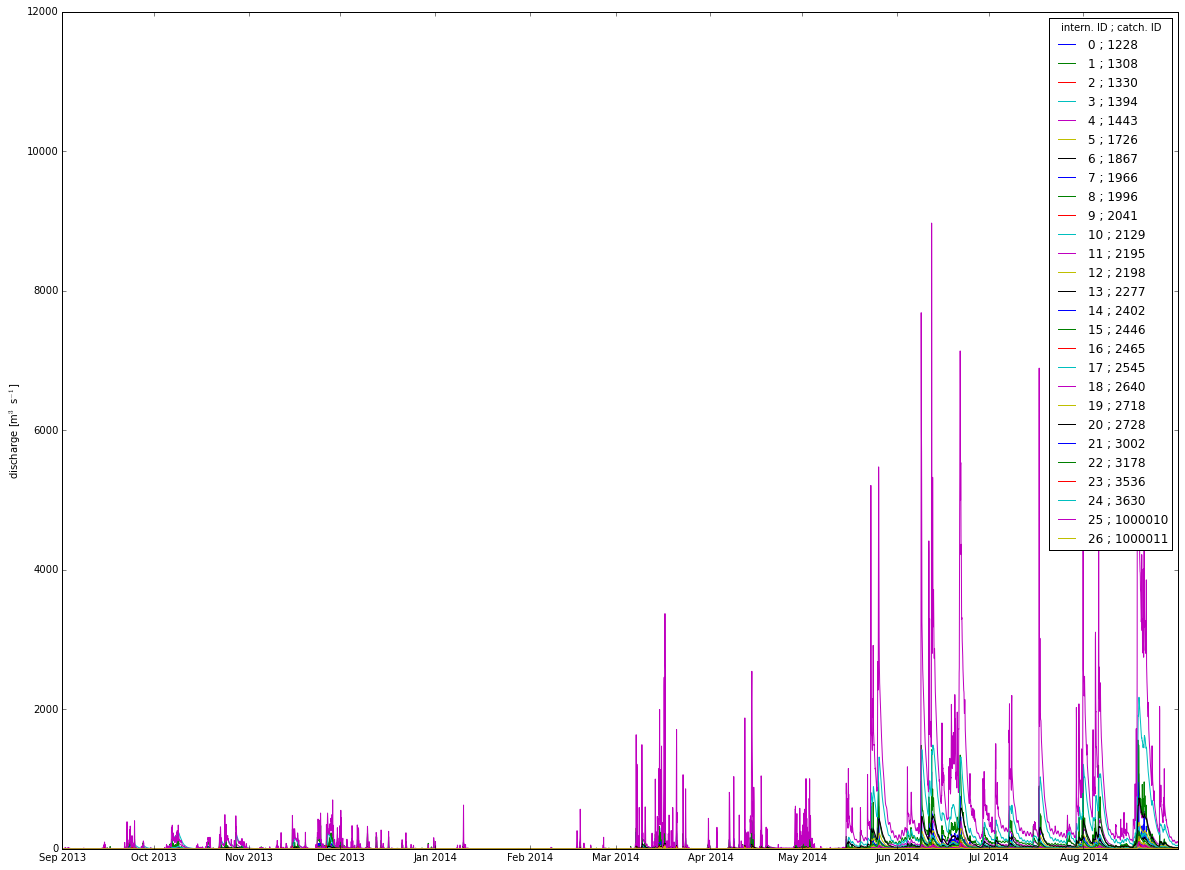

In [27]:
# We can start by making a quick plot of the data

fig, ax = plt.subplots(figsize=(20,15))

# plot each catchment discharge in the list
for i,d in enumerate(discharge_ts):
    ax.plot(sim_dates, d, label = "{} ; {}".format(str(i), catchment_id_map[i]))

ax.legend(title="intern. ID ; catch. ID")
ax.set_ylabel("discharge [m$^3$ s$^{-1}$]")

####b) Get the Snow Cover Fraction (SCF) of all cells for a certain point in time

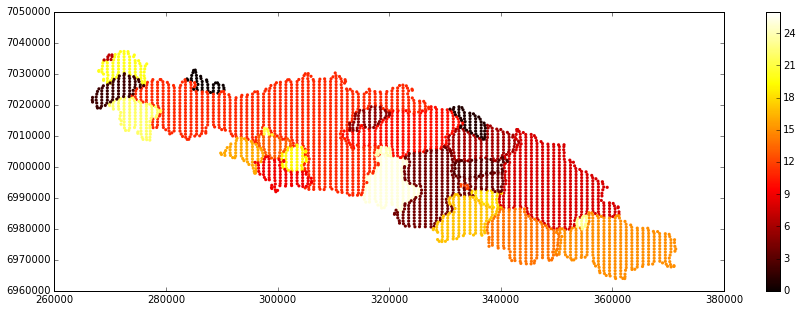

In [36]:
# If we're interested to look at values of individual cells, rather
# than at the catchment level, we can do that also. Shyft does not have
# an underlying 'raster' model, so you need to fetch all cells directlry
# from the simulator object
cells = simulator.region_model.get_cells()


# Once we have the cells, we can get their coordinate information
# and fetch the x- and y-location of the cells
x = [cell.geo.mid_point().x for cell in cells]
y = [cell.geo.mid_point().y for cell in cells]

# If you want to know the membership to each catchment
# of the cells, you can get a list of catchment ids for each cell
catch_ids = np.array([cell.geo.catchment_id() for cell in cells])

# and make a catchment map...
# using a scatter plot of the cells
fig, ax = plt.subplots(figsize=(15,5))
cm = plt.cm.get_cmap('hot')
plot = ax.scatter(x, y, c=catch_ids, marker='.', s=40, lw=0, cmap=cm)
plt.colorbar(plot)

In [41]:
# Here we'll do some more work to look at the timeseries data in each of the cells

# This example is collecting the time series of a response variable (here the SCF)
# for each of the cells

# set a date: year, month, day, hour of day
date = datetime.datetime(2014,7,10,23) 

try:
    idx = sim_dates.index(date) # index of date on time-axis
except:
    print("Date out of range, setting index to 0")
    idx = 0

# fetching SCF (the response variable is named "snow_sca")
# You can use tab-completion to explore the `rc`, short for "response collector"
# object of the cell.
scf = [cell.rc.snow_sca.v[idx] for cell in cells]

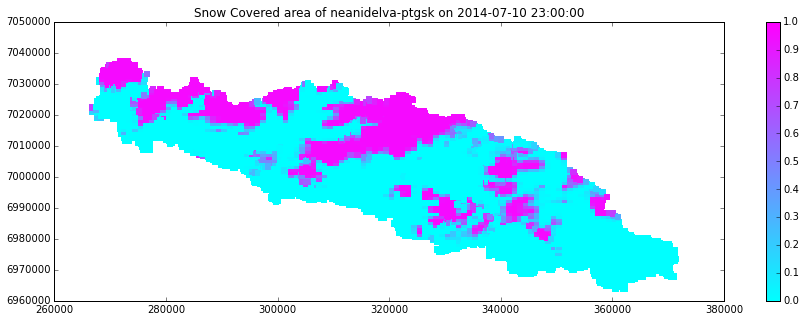

In [42]:
# And finally we can make a simple scatter plot for quick visualization
fig, ax = plt.subplots(figsize=(15,5))
cm = plt.cm.get_cmap('cool')
plot = ax.scatter(x, y, c=scf, vmin=0, vmax=1, marker='s', s=40, lw=0, cmap=cm)
plt.colorbar(plot)
plt.title('Snow Covered area of {0} on {1}'.format(simulator.config.region_model_id, date))


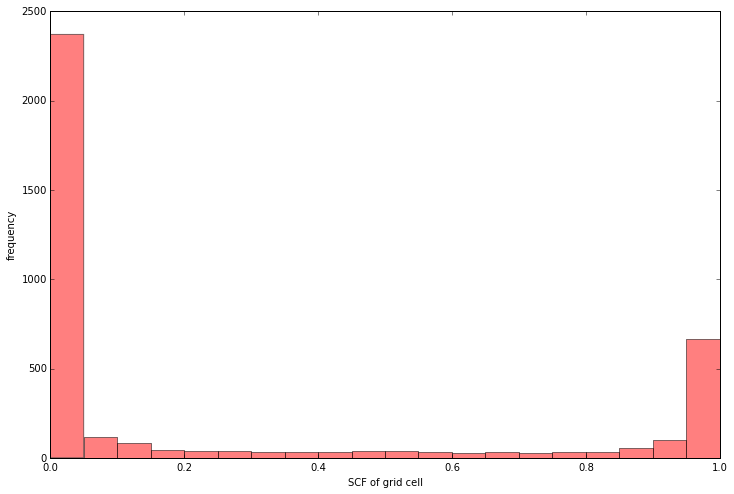

In [43]:
# And let's compute histogram of the snow covered area as well
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(scf, bins=20, range=(0,1), color='r', alpha=0.5)
ax.set_xlabel("SCF of grid cell")
ax.set_ylabel("frequency")